In [ ]:
#------------IMPORTING lIBRARIES------------
from google.colab import drive
import zipfile
import os

#mounting google drive
drive.mount('/content/drive')

#defining path
zip_path = "/content/drive/My Drive/Colab Notebooks/data/alzheimers1.zip"
extract_path = "/content/alzheimers1/alzheimers/Combined_Dataset/train/alzheimers/Combined_Dataset/train/alzheimers/Combined_Dataset/train/alzheimers/Combined_Dataset/train"

#extracting:
if not os.path.exists(extract_path):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print("Data extracted!")
else:
  print("Data already extracted. Skipping unzip.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data already extracted. Skipping unzip.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2 #using a pre-traine dmodel without the top
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D


In [ ]:
#----------------DATA PRE PROCESSING---------------------
# Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 30,
                                   zoom_range=0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range= 0.2,
                                   shear_range=0.2,
                                   horizontal_flip= True,
                                   validation_split=0.2)

#load training and validation sets:
training_set = train_datagen.flow_from_directory(
    extract_path, #used to point to the unzipped fl=olders
    target_size=(224, 224), #resizing images
    batch_size=32,
    class_mode='categorical', #there are 4 classes of classification:
    subset='training',
)

validation_set = train_datagen.flow_from_directory(
    extract_path,
    target_size=(224, 224), #resizing images
    batch_size=32,
    class_mode='categorical', #there are 4 classes of classification:
    subset='validation',
)

Found 8192 images belonging to 4 classes.
Found 2048 images belonging to 4 classes.


In [ ]:
#Debugging to find the right path with the 4 classes:
!ls /content/alzheimers1/alzheimers/Combined_Dataset/train/alzheimers/Combined_Dataset/train/alzheimers/Combined_Dataset/train/alzheimers/Combined_Dataset/train

'Mild Impairment'      'No Impairment'
'Moderate Impairment'  'Very Mild Impairment'


In [ ]:
#------------------BUILDING THE CNN----------------------
#loading MobildeNetV2 without top layer
base_model = MobileNetV2(
    input_shape= (224, 224, 3),
    include_top = False,
    weights = 'imagenet'
)

#add custon head
base_model.trainable = False

# Build CNN Model with custom head
model = Sequential([base_model,
                      GlobalAveragePooling2D(),
                      Dropout(0.5),
                      Dense(4, activation='softmax')
                    ])

'''
# Add more convolutional layers with increasing filters
model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # Add dropout to reduce overfitting
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))


#Flattening:
model.add(Flatten())

#Fully COnnected Layers
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4, activation='softmax')) #for multivariate classification to convert the outputs into probabilities
'''

#compiling the model with a lower learning rate for more precision:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])


#Model Summary:
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#----------------CALLBACKS------------------
# Callbacks: Early Stopping and Model Checkpoint
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)


In [ ]:
#-------------TRAIN MODEL----------------
# Train the model with validation set
history = model.fit(
  training_set,
  epochs=35,
  validation_data=validation_set,
  callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.2617 - loss: 1.8827
Epoch 1: val_accuracy improved from -inf to 0.41943, saving model to best_model.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 142s 514ms/step - accuracy: 0.2618 - loss: 1.8822 - val_accuracy: 0.4194 - val_loss: 1.2524
Epoch 2/35
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.3327 - loss: 1.5559
Epoch 2: val_accuracy improved from 0.41943 to 0.50537, saving model to best_model.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 127s 497ms/step - accuracy: 0.3328 - loss: 1.5557 - val_accuracy: 0.5054 - val_loss: 1.1267
Epoch 3/35
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.3958 - loss: 1.4033
Epoch 3: val_accuracy improved from 0.50537 to 0.52734, saving model to best_model.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 127s 496ms/step - accuracy: 0.3959 - loss: 1.4032 - val_accuracy: 0.5273 - val_loss: 1.0616
Epoch 4/35
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.4408 - loss: 1.2980
Epoch 4: val_accuracy

In [ ]:
#-------------MODEL ASSESSMENT--------------------
# Evaluate on the validation set
val_loss, val_accuracy = model.evaluate(validation_set)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 388ms/step - accuracy: 0.6184 - loss: 0.8432
Validation Accuracy: 62.45%


<Figure size 1400x600 with 0 Axes>

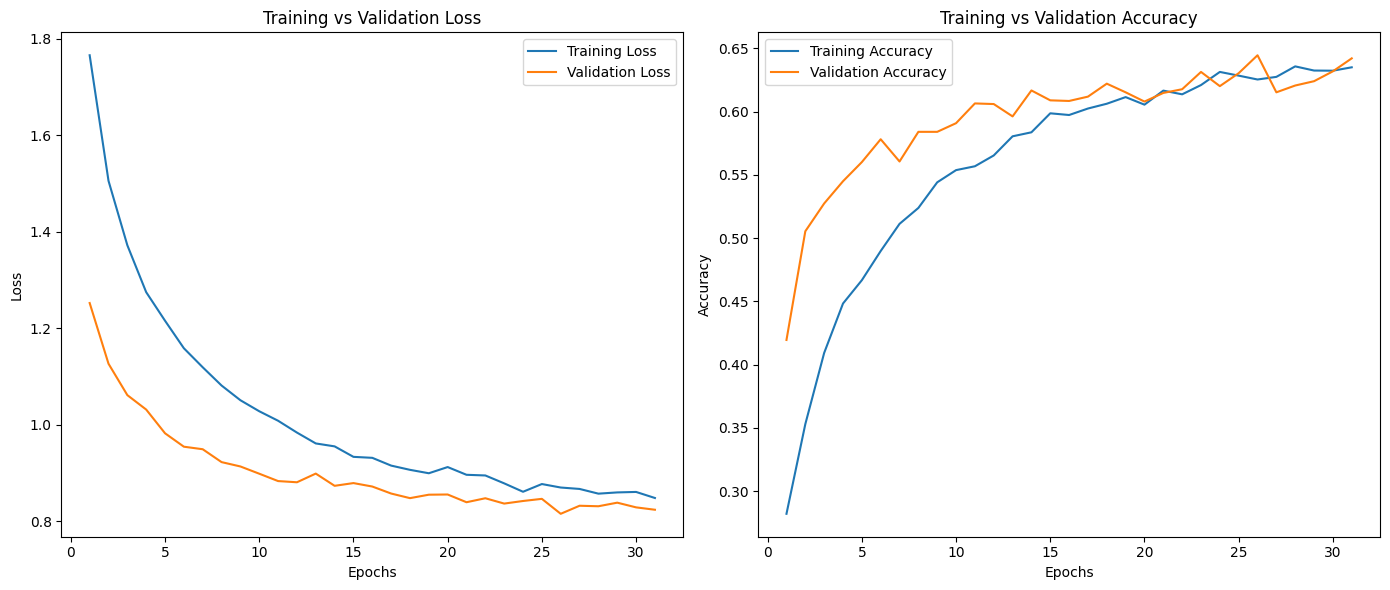

In [ ]:
#-------------VIZUALIZING TRAINING PERFORMANCE--------------
# Extract loss and val_loss
loss = history.history['loss']
val_loss = history.history['val_loss']
# Optional: Extract accuracy if you used it
if 'accuracy' in history.history:
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
elif 'mae' in history.history: # You used MAE in your compile step
  acc = history.history['mae']
  val_acc = history.history['val_mae']
else:
  acc = val_acc = None

# Plot
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(14, 6))

# Optional: Extract accuracy if you used it
if 'accuracy' in history.history:
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
elif 'mae' in history.history: # You used MAE in your compile step
  acc = history.history['mae']
  val_acc = history.history['val_mae']
else:
  acc = val_acc = None

# Plot
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(14, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# MAE or Accuracy plot
if acc is not None:
  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label='Training MAE' if 'mae' in history.history else 'Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation MAE' if 'mae' in history.history
else 'Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('MAE' if 'mae' in history.history else 'Accuracy')
  plt.title('Training vs Validation ' + ('MAE' if 'mae' in history.history else 'Accuracy'))
  plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
!ls '/content/alzheimers1/alzheimers/Combined_Dataset/train/alzheimers/Combined_Dataset/train/alzheimers/Combined_Dataset/train/alzheimers/Combined_Dataset/test'
extract_path2 = '/content/alzheimers1/alzheimers/Combined_Dataset/train/alzheimers/Combined_Dataset/train/alzheimers/Combined_Dataset/train/alzheimers/Combined_Dataset/test'

'Mild Impairment'      'No Impairment'
'Moderate Impairment'  'Very Mild Impairment'


In [ ]:
#-------------PREPARING THE TEST DATA SET---------------
# Test Data Preprocessing
test_set = train_datagen.flow_from_directory(
  extract_path2,
  target_size=(224, 224),
  batch_size=32,
  class_mode='categorical',
)

Found 1279 images belonging to 4 classes.


In [ ]:
#---------EVAL ON TEST DATA---------------
# Evaluate on the test data
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 487ms/step - accuracy: 0.5158 - loss: 0.9865
Test Accuracy: 53.24%


In [ ]:
#----------PREDICTING ON NEW IMAGES--------------------
# Function for Predicting a Single Image
def predict_single_image(model, image_path):
  img = load_img(